# Imports

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, roc_curve
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np

2024-06-10 14:51:11.431850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 14:51:11.432006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 14:51:11.619620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data and Models

In [2]:
# Load training and test data
X_train = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/X_train_normalized.csv", index_col=[0])
X_test = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/X_test_normalized.csv", index_col=[0])
y_train = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/y_train.csv", index_col=[0])
y_test = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/y_test.csv", index_col=[0]).reset_index(drop=True)

In [3]:
# Paths to models
model_paths = [
    '/kaggle/input/ibm-classification-logistic-regression/lr_model.pkl',
    '/kaggle/input/ibm-classification-xgboost/xgb_model.pkl',
] + [f'/kaggle/input/ibm-classification-lstm/lstm_model_{i}.keras' for i in range(5)]

# Load models (LSTM in different format)
models = []
for p in model_paths[:2]:
    with open(p, 'rb') as file:
        models.append(pickle.load(file))
for p in model_paths[2:]:
    models.append(load_model(p))

# Get mapping from index of list to name of model
model_map = {
    0: 'Logistic Regression',
    1: 'XGBoost',
    2: 'LSTM'
}

# Get number of models for ease
num_models = len(model_map)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:52:18] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:52:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


# Results Analysis

### LSTM Data Prep

In [4]:
def prep_data_for_lstm(df, window):
    """Function to put data in the correct format for LSTM. It assumes that the 'Target' is the last column of the dataframe. Note that 
    we get data 1 stock at a time so that the lookback window is for the same stock rather than different stocks"""
    
    # Get unique stock ids
    stock_ids = df['Symbol'].unique()

    # Array to store X and y
    X = []
    y = []
    
    # Array to store stock IDs and Dates so we can join onto actuals when making predictions
    ids = []
    dates = []
    
    # Loop through each stock and apply rolling window
    for s in stock_ids:
        # Get data for that stock
        stock_data_df = df[df['Symbol'] == s].drop(['Symbol'], axis=1).reset_index(drop=True)
        stock_data_numpy = stock_data_df.drop(['Date'], axis=1).to_numpy()

        # Loop through each index in the dataframe and get X and y
        for i in range(len(stock_data_numpy)-window):
            # Get stock ID and Date and append to lists
            ids.append(s)
            date = stock_data_df.loc[df.index[i + window], 'Date']
            dates.append(date)
            
            # Get values in window and wrap each one in a list
            row = stock_data_numpy[i: i+window]
            X.append(row)

            # Get the label (first value after the window)
            label = stock_data_numpy[i + window][-1]
            y.append(label)

    return np.array(X), np.array(y), np.array(ids), np.array(dates)

In [5]:
# Get training and test data for lstm predictions
df_train  = pd.concat([X_train, y_train], axis=1)
df_test  = pd.concat([X_test, y_test], axis=1)
X_train_lstm, y_train_lstm, ids_train, dates_train = prep_data_for_lstm(df=df_train, window=5)
X_test_lstm, y_test_lstm, ids_test, dates_test = prep_data_for_lstm(df=df_test, window=5)

### Make Predictions

In [6]:
# Drop first 5 rows of each stock (LSTM can't predict these) for test set
df_test_trimmed = df_test.groupby('Symbol').apply(
    lambda x: x.tail(len(x) - 5)
).reset_index(drop=True)
X_test_trimmed = df_test_trimmed.drop('1-week Forward Return Sign', axis=1)
y_test_trimmed = df_test_trimmed['1-week Forward Return Sign']

# Drop first 5 rows of each stock (LSTM can't predict these) for training set
df_train_trimmed = df_train.groupby('Symbol').apply(
    lambda x: x.tail(len(x) - 5)
).reset_index(drop=True)
X_train_trimmed = df_train_trimmed.drop('1-week Forward Return Sign', axis=1)
y_train_trimmed = df_train_trimmed['1-week Forward Return Sign']

/tmp/ipykernel_18/1917942196.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_trimmed = df_test.groupby('Symbol').apply(
/tmp/ipykernel_18/1917942196.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_trimmed = df_train.groupby('Symbol').apply(


In [7]:
# Make predictions on test set for first two models
y_pred = [m.predict(X_test_trimmed.drop(['Date', 'Symbol'], axis=1)) for m in models[:2]]

# Make predicitions on training set for first two models to test for overfitting
y_pred_train = [m.predict(X_train_trimmed.drop(['Date', 'Symbol'], axis=1)) for m in models[:2]]

In [8]:
def lstm_predict(X_lstm, models):
    """Function to make mean predictions using the 5 LSTM models"""
    
    # List to store predictions
    all_preds = []
    
    # Make prediction for each model
    for m in models:
        preds = m.predict(X_lstm).flatten()
        all_preds.append(preds)
    
    # Calculate mean prediction
    mean_preds = np.mean(np.stack(all_preds), axis=0)
    
    # Convert probability to classification
    y_pred_lstm = np.where(mean_preds >= 0.5, 1, 0)
    
    return y_pred_lstm, mean_preds

In [9]:
# Make predictions on test set for lstm
y_pred_lstm, test_probabilities = lstm_predict(X_lstm=X_test_lstm, models=models[2:])

# Make predictions on training set for lstm to test for overfitting
y_pred_train_lstm, train_probabilities = lstm_predict(X_lstm=X_train_lstm, models=models[2:])

4749/4749 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
4749/4749 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
4749/4749 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
4749/4749 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
4749/4749 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
19569/19569 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step
19569/19569 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step
19569/19569 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step
19569/19569 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step
19569/19569 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step


In [10]:
# Get LSTM predictions together with their Date and Symbol
lstm_train_df = pd.DataFrame(
    data=zip(dates_train, ids_train, y_pred_train_lstm, train_probabilities),
    columns=['Date', 'Symbol', 'Prediction', 'Probability']
)
lstm_test_df = pd.DataFrame(
    data=zip(dates_test, ids_test, y_pred_lstm, test_probabilities),
    columns=['Date', 'Symbol', 'Prediction', 'Probability']
)

# Join LSTM predictions using corresponding Date and Symbol to get them in the right order relative to the other models
lstm_train_preds_probs = pd.merge(
    left=X_train_trimmed,
    right=lstm_train_df,
    on=['Date', 'Symbol']
)[['Prediction', 'Probability']]
lstm_test_preds_probs = pd.merge(
    left=X_test_trimmed,
    right=lstm_test_df,
    on=['Date', 'Symbol']
)[['Prediction', 'Probability']]

# Append predictions for LSTM to predictions list for all models
y_pred.append(np.array(lstm_test_preds_probs['Prediction']))
y_pred_train.append(np.array(lstm_train_preds_probs['Prediction']))

### Confusion Matrix
The confusion matrix shows us how our predicted labels compare to our actual labels.

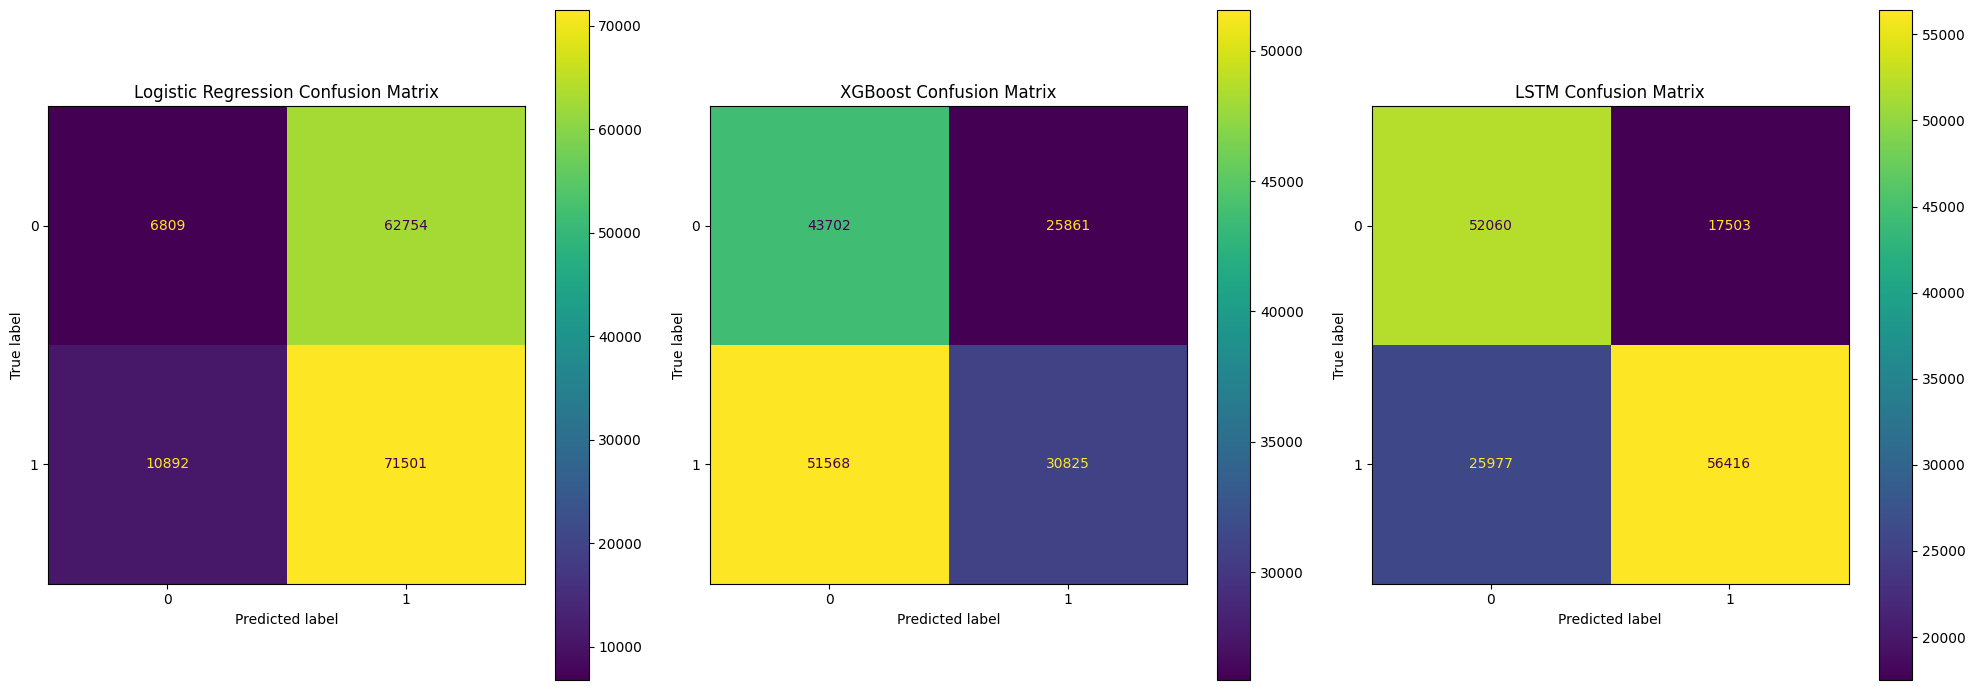

In [11]:
#################################
# Plot confusion matrices
#################################

# Set up subplot
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(20, 7))

# Plot
for i, m in model_map.items():
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_trimmed, y_pred[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Note not every model may have this classes_ property
    
    # Plot
    disp.plot(ax=axes[i], cmap='viridis')
    axes[i].set_title(f'{m} Confusion Matrix')
    
# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Accuracy, Precision, Recall, F1-Score
* **Accuracy**: Measure of how good the classifier is at predicting correctly. It's simply the number of predictions the classifier got right divided by the total number of predicitions it made. In the confusion, matrix, it's the sum of the leading diagonal divided by the sum of the whole matrix.

* **Precision**: For a given class, this measures how good the classifier is at not incorrectly labelling something as the class. For the given class, it's simply the number of predictions that were correctly labelled as that class divided by the total number of predictions that were labelled with that class.

* **Recall**: For a given class, this measures how good the classifier is at correctly labelling something as that class. For the given class, it's simply the number of predictions that were correctly labelled as that class divided by the total number of actual instances of that class.

* **F1-Score**: For a given class, this is a weighted harmonic mean of precision and recall where each are given equal importance. The best F1-score is 1 and the worst is 0.

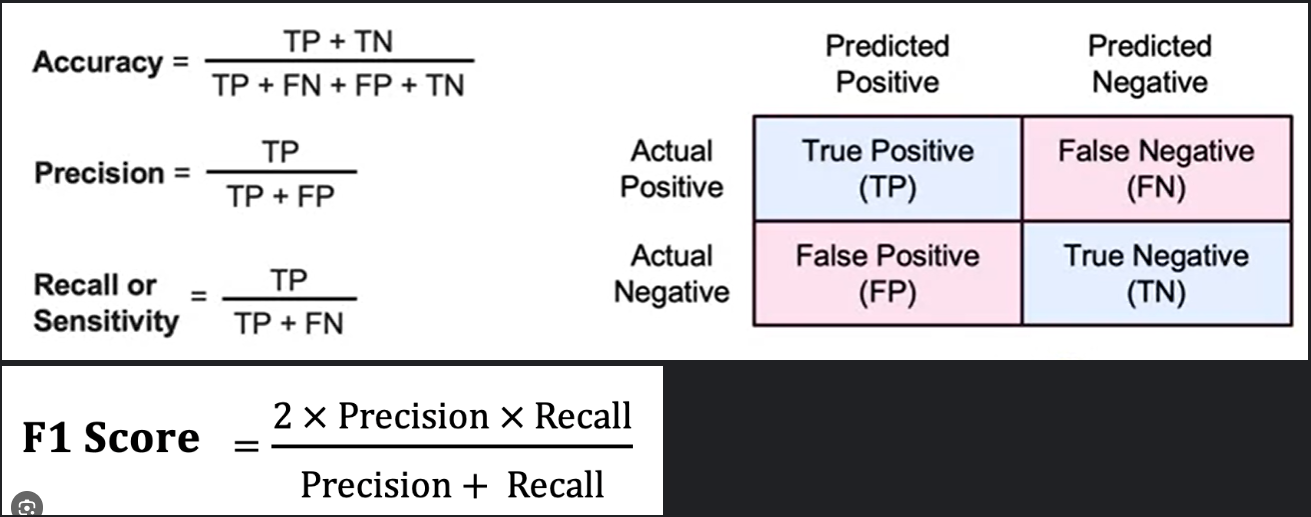

In [12]:
# Accuracy
for i in range(num_models):
    accuracy_test = accuracy_score(y_test_trimmed, y_pred[i])
    accuracy_train = accuracy_score(y_train_trimmed, y_pred_train[i])
    print(f"{model_map[i]} Test Accuracy {accuracy_test}")
    print(f"{model_map[i]} Training Accuracy {accuracy_train}")
    print("\n")

Logistic Regression Test Accuracy 0.5153465476848561
Logistic Regression Training Accuracy 0.5807395885567547


XGBoost Test Accuracy 0.4904511832372529
XGBoost Training Accuracy 0.6479927689216942


LSTM Test Accuracy 0.7138645397351865
LSTM Training Accuracy 0.7867710233061742




In [13]:
# Classification report showing precision, recall and F1 score for each class, as well accuracy and some averages
for i in range(num_models):
    cr = classification_report(y_test_trimmed, y_pred[i], digits=3)
    print(f"{model_map[i]}")
    print(cr)
    print("\n")

Logistic Regression
              precision    recall  f1-score   support

         0.0      0.385     0.098     0.156     69563
         1.0      0.533     0.868     0.660     82393

    accuracy                          0.515    151956
   macro avg      0.459     0.483     0.408    151956
weighted avg      0.465     0.515     0.429    151956



XGBoost
              precision    recall  f1-score   support

         0.0      0.459     0.628     0.530     69563
         1.0      0.544     0.374     0.443     82393

    accuracy                          0.490    151956
   macro avg      0.501     0.501     0.487    151956
weighted avg      0.505     0.490     0.483    151956



LSTM
              precision    recall  f1-score   support

         0.0      0.667     0.748     0.705     69563
         1.0      0.763     0.685     0.722     82393

    accuracy                          0.714    151956
   macro avg      0.715     0.717     0.714    151956
weighted avg      0.719     0.714    

### ROC Curve

Remember that the Logistic Regression algorithm uses probabilities to predict the class of a sample. For example, if the probability the sample belongs to class A is greater than 0.5 then it will be classified as Class A and if it's less than 0.5 it will be classified as Class B. This probability (0.5 in this case) is called the 'classification threshold'. A higher/lower classification threshold can change which data samples get classified as each class.

The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate (aka. recall) against the False Positive Rate for varying levels of this classification threshold. As shown in the image below, TPR is simply the number of true positives relative to the total number of positives and FPR is the number of false positives relative to the total number of negatives. 

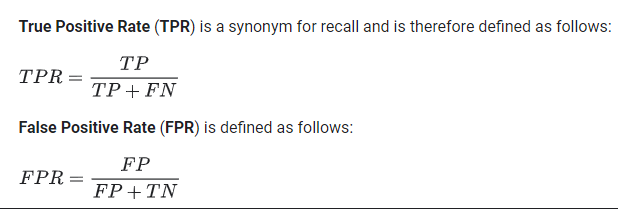

A typical ROC curve is shown below. The classification threshold is DECREASING from left to right. As we decrease the classification threshold, we classify more items as postiive, hence increasing both true positives and false positives.

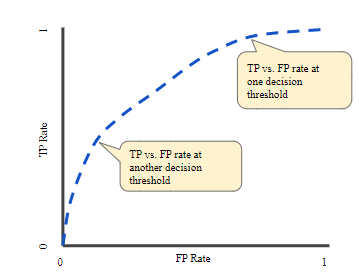

Note to plot this curve, we would need to train a model and then vary the classification threshold between 0 and 1 and calculate the TPR and FPR for each one.

### AUC

AUC stands for area under the ROC curve. It gives us an aggregate measure of performance across all classification thresholds. Since TPR and FPR are between 0 and 1, the value of AUC is also between 0 and 1.

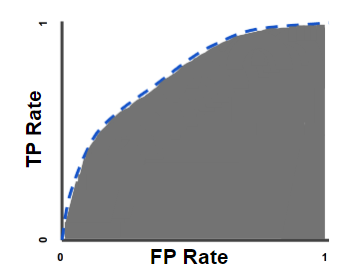

We can interpret AUC as the probability that a random positive example is assigned a higher probability by the regression model than a random negative sample. If the predictions are 100% correct, AUC will be 1 and if they're 100% wrong it will be 0. If the AUC is 0.5 then the model makes predicitions no better than random guessing.

Logistic Regression AUC is 0.4528484608424331
XGBoost AUC is 0.49157676775269066
LSTM AUC is 0.7602527052401167


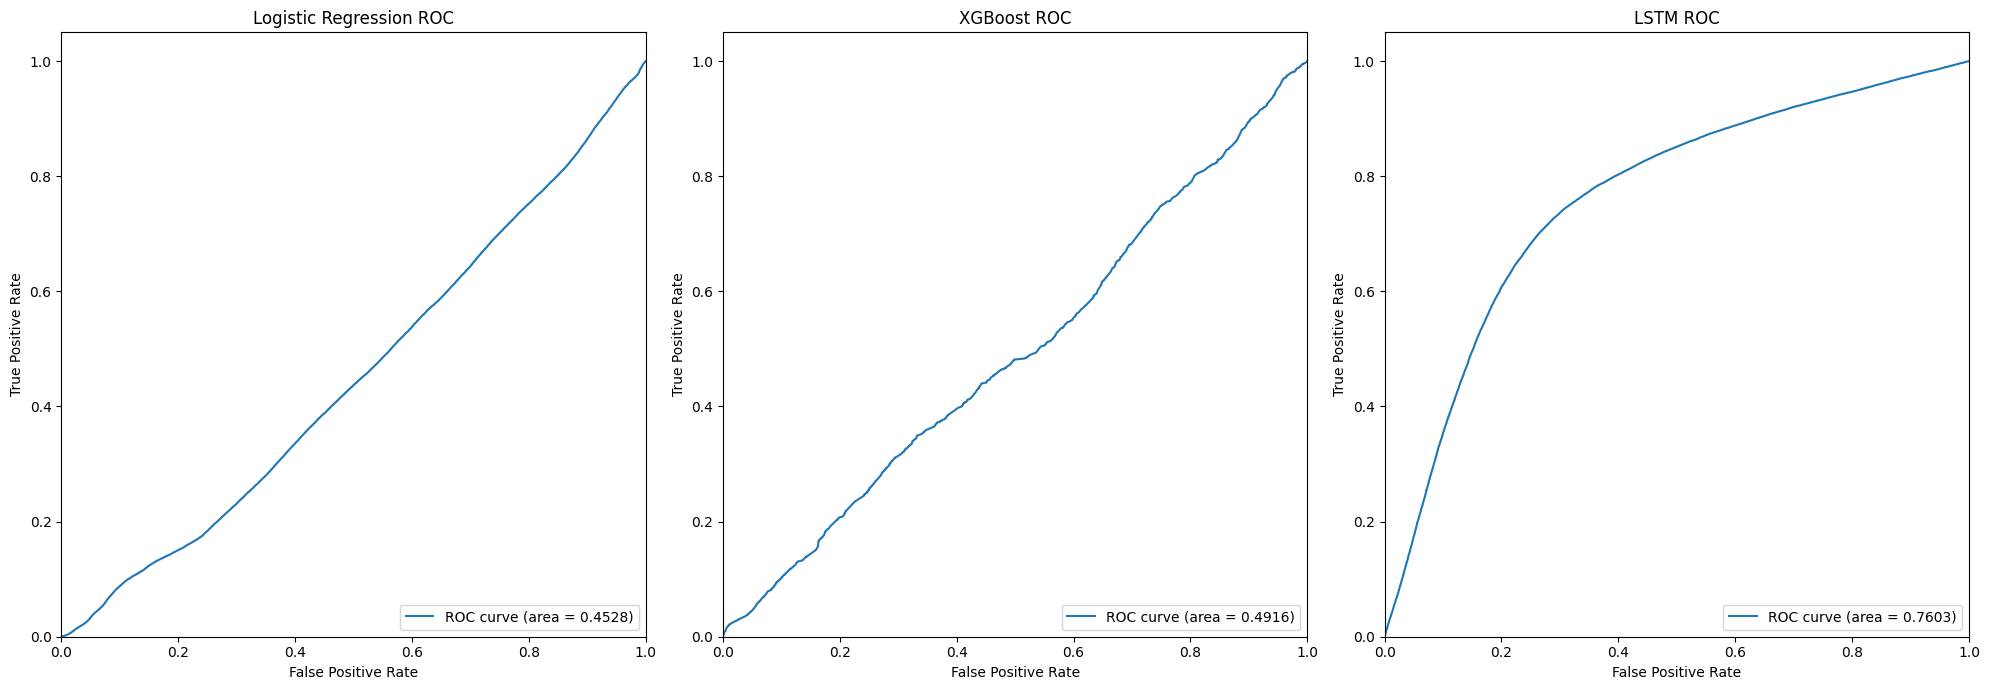

In [14]:
# Import
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Setup subplots
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(20, 7))

# Get probabilities of positive class
for i, m in model_map.items():
    if m != 'LSTM':
        y_pred_prob = models[i].predict_proba(X_test_trimmed.drop(['Date', 'Symbol'], axis=1))[:, 1]
    else:
        y_pred_prob = np.array(lstm_test_preds_probs['Probability'])
    
    # Compute roc curve
    fpr, tpr, thresholds = roc_curve(y_test_trimmed, y_pred_prob)

    # Compute AUC
    auc = roc_auc_score(y_test_trimmed, y_pred_prob)
    print(f"{m} AUC is {auc}")

    # Plot ROC curve
    ax = axes[i]
    ax.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{m} ROC')
    ax.legend(loc="lower right")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Strategies

### Data Prep

In [15]:
# Read data from feature engineering notebook
df = pd.read_csv("/kaggle/input/ibm-classification-eda/data.csv", index_col=[0], parse_dates=['Date']).reset_index(drop=True)
df['Symbol'] = df['Symbol'].rank(method='dense', ascending=False).astype(int)

# Convert Date type
lstm_test_df['Date'] = pd.to_datetime(lstm_test_df['Date'])

In [16]:
df = pd.merge(
    left=lstm_test_df,
    right=df[['Date', 'Symbol', 'Adj Close', 'S&P500']],
    on=['Date', 'Symbol']
).sort_values(by='Date')

In [17]:
df

,Date,Symbol,Prediction,Probability,Adj Close,S&P500
0,2021-01-11,139,0,0.316001,56.746449,3799.61
127332,2021-01-11,387,1,0.605455,20.139999,3799.61
24624,2021-01-11,85,0,0.419873,102.573013,3799.61
127008,2021-01-11,129,1,0.579239,12.195695,3799.61
24948,2021-01-11,120,0,0.424258,141.771652,3799.61
...,...,...,...,...,...,...
54107,2022-04-22,355,1,0.561202,61.200001,4271.78
16847,2022-04-22,432,1,0.508739,242.919998,4271.78
84239,2022-04-22,116,0,0.359490,51.062027,4271.78
147095,2022-04-22,118,0,0.386963,102.690002,4271.78


In [18]:
# Calculate Forward Return
df['1-week Forward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(-5)
df['1-week Forward Return'] = (df['1-week Forward Adj Close'] - df['Adj Close']) / df['Adj Close']

# Drop redundant columns
df.drop(['1-week Forward Adj Close', 'Probability', 'Adj Close'], axis=1, inplace=True)

In [19]:
# Calculate forward return of S&P 500
df['1-week Forward S&P500'] = df.groupby('Symbol')['S&P500'].shift(-5)
df['1-week Forward Return S&P500'] = (df['1-week Forward S&P500'] - df['S&P500']) / df['S&P500']
df.drop(['1-week Forward S&P500', 'S&P500'], axis=1, inplace=True)

# Drop NaNs at end of time
df.dropna(inplace=True)

In [20]:
##############################################################################################
# Calculate cumulative return for long-short equally weighted portfolio, rebalanced weekly
##############################################################################################
# Calculate return based on long/short position
df['Position'] = 1# df['Prediction'].replace({0: -1})
df['Strategy Stock Return'] = df['1-week Forward Return'] * df['Position']
df['1-week Forward Strategy Return'] = df.groupby('Date')['Strategy Stock Return'].transform(func='mean')

<Axes: xlabel='Date'>

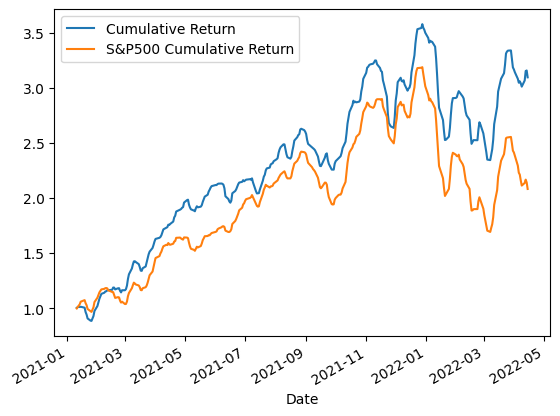

In [21]:
# TODO REFACTOR THIS NOTEBOOK TO MAKE IT MUCH CLEANER AND HAVE ALL THREE STRATEGIES
strategy_df = df[['Date', '1-week Forward Strategy Return', '1-week Forward Return S&P500']].drop_duplicates('Date').reset_index(drop=True)
strategy_df['Cumulative Return'] = (1 + strategy_df['1-week Forward Strategy Return']).cumprod()
strategy_df['S&P500 Cumulative Return'] = (1 + strategy_df['1-week Forward Return S&P500']).cumprod()
strategy_df.plot(x='Date', y=['Cumulative Return', 'S&P500 Cumulative Return'])